In [2]:
import numpy as np
import rioxarray as rx
import rasterio
from rasterio.mask import mask
from pathlib import Path
import geopandas as gpd
import pprint
import re
import os
import glob
import xarray as xr
import matplotlib.pyplot as plt
import xarray
import pandas as pd
from exactextract import exact_extract
%matplotlib inline

In [558]:
def fire_year_from_base(filename):
  """takes filepath and returns year of fire
  """
  name = re.sub(r'^.*/', "", filename)  
  name = str(name)
  year = name.split('_')[1] # 1 returns the second object in the list (first object is always 0). [#] refers to index position
  return year

def match_coords(img, ref):
    result = img.assign_coords({
    "lon": ref.lon,
    "lat": ref.lat,})
    return result


def getName(filename):
  """ takes in filepath and returns the name of the file for a tif 
  """
  name = re.sub(r'^.*/', "", filename)
  name = name.replace("_pp", "")
  name = name.replace("_nbr", "")
  name = name.split(".")[-0]
  return name

def check_shp_exists(shp, name):
  if name in shp:
    res = 1
  else:
    res = 0
  return res


def clipRastersTIF(in_path, shpfile, out_path):
 pathlist = Path(in_path).rglob('*.tif')
 for path in pathlist:
  path_in_str = str(path)
  src = rx.open_rasterio(path)
  name = getName(path_in_str)
  print(name)
  src_lonlat = src.rio.reproject("epsg:4326") 
  shp = gpd.read_file(shpfile)
  shp = shp[shp.Fire_ID == name]
  clipped = src_lonlat.rio.clip(shp.geometry.values, shp.crs, drop=True, invert=False)
  out_dir = out_path + name +".tif"
  clipped.rio.to_raster(out_dir, driver="GTiff", compress="LZW")


def raster_stats(ras):
  median =  ras.median()
  mean = ras.mean()
  std = ras.std()
  median = median.to_pandas()
  mean = mean.to_pandas()
  std = std.to_pandas()
  cv = std/mean
  return (mean, median, cv)
    
def calc_rbr(ras):
  '''returns a new raster consisting of rbr (2) , and a dataframe consisting of median, mean and cv rbr'''
  pre = ras[0]
  post = ras[2]
  post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})
  new_raster=(((pre - post)*1000)/ pre + 1.001)
  mean, median, cv = raster_stats(new_raster)
  df = pd.DataFrame({
    "Fire_ID": [name],
    "rbr_median": [median],
    "rbr_mean": [mean],
    "rbr_cv": [cv]
    })
  return (df, new_raster)



def nc_to_xarray(img, sets):
  """ converts nc files with unorganized bands from either nbr grouping (sets) or pp grounping and converts to xr array
  """
    # get years
    year = int(fire_year_from_base(nbr_nc)) #coerce to integer
    if sets == "nbr":
        end = year + 11 # add 10 years 
        years = list(range(year, end))
        # deleted postNBR year (year 1)
        del years[1] 
        #filter bands
        nbr0=img.rename_vars(Band10="nbr")['nbr']
        nbr2=img.rename_vars(Band1="nbr")['nbr']
        nbr3=img.rename_vars(Band2="nbr")['nbr']
        nbr4=img.rename_vars(Band3="nbr")['nbr']
        nbr5=img.rename_vars(Band4="nbr")['nbr']
        nbr6=img.rename_vars(Band5="nbr")['nbr']
        nbr7=img.rename_vars(Band6="nbr")['nbr']
        nbr8=img.rename_vars(Band7="nbr")['nbr']
        nbr9=img.rename_vars(Band8="nbr")['nbr']
        nbr10=img.rename_vars(Band9="nbr")['nbr']

        # make sure coordinates match
        nbr2= match_coords(nbr2, nbr0)
        nbr3= match_coords(nbr3, nbr0)
        nbr4= match_coords(nbr4, nbr0)
        nbr5= match_coords(nbr5, nbr0)
        nbr6= match_coords(nbr6, nbr0)
        nbr7= match_coords(nbr7, nbr0)
        nbr8= match_coords(nbr8, nbr0)
        nbr9= match_coords(nbr9, nbr0)
        nbr10= match_coords(nbr10, nbr0)

        #concat
        da = xr.concat([nbr0, nbr2, nbr3, nbr4, nbr5, nbr6, nbr7, nbr8, nbr9, nbr10], dim=pd.Index(years, name='time'))
    if sets == "pp":
        start = year - 1
        end = year + 2 # add 10 years 
        years = list(range(start, end))
        # deleted postNBR year (year 1)
        del years[1] 
        #filter bands
        preNBR= img.rename_vars(Band1='nbr')['nbr']
        postNBR= img.rename_vars(Band2='nbr')['nbr']

        # make sure coordinates match
        postNBR= match_coords(postNBR, preNBR)
        
        #concat
        da = xr.concat([preNBR, postNBR], dim=pd.Index(years, name='time'))


    da.attrs['long_name'] = "nbr"
    return(da)

        
        

def combine_nc_to_xarray(nbr_img, pp_img, filename):
    img = nbr_img
    img2 = pp_img
    filename =str(filename)
    # get years
    year = int(fire_year_from_base(filename)) #coerce to integer
    start = year - 1
    end = year + 11 # add 10 years 
    years = list(range(start, end))
    #filter bands
    nbr0=img.rename_vars(Band10="nbr")['nbr']
    nbr2=img.rename_vars(Band1="nbr")['nbr']
    nbr3=img.rename_vars(Band2="nbr")['nbr']
    nbr4=img.rename_vars(Band3="nbr")['nbr']
    nbr5=img.rename_vars(Band4="nbr")['nbr']
    nbr6=img.rename_vars(Band5="nbr")['nbr']
    nbr7=img.rename_vars(Band6="nbr")['nbr']
    nbr8=img.rename_vars(Band7="nbr")['nbr']
    nbr9=img.rename_vars(Band8="nbr")['nbr']
    nbr10=img.rename_vars(Band9="nbr")['nbr']

    # make sure coordinates match
    nbr2= match_coords(nbr2, nbr0)
    nbr3= match_coords(nbr3, nbr0)
    nbr4= match_coords(nbr4, nbr0)
    nbr5= match_coords(nbr5, nbr0)
    nbr6= match_coords(nbr6, nbr0)
    nbr7= match_coords(nbr7, nbr0)
    nbr8= match_coords(nbr8, nbr0)
    nbr9= match_coords(nbr9, nbr0)
    nbr10= match_coords(nbr10, nbr0)

    # pre nbr
    preNBR= img2.rename_vars(Band1='nbr')['nbr']
    postNBR= img2.rename_vars(Band2='nbr')['nbr']

    # make sure coordinates match
    postNBR= match_coords(postNBR, nbr0)
    preNBR= match_coords(preNBR, nbr0)

    #concat
    da = xr.concat([preNBR, nbr0, postNBR, nbr2, nbr3, nbr4, nbr5, nbr6, nbr7, nbr8, nbr9, nbr10], dim=pd.Index(years, name='time'))
    
    da.attrs['long_name'] = "nbr"
    return(da)


def combine_write_to_xarray(nbr_in_path, pp_in_path, out_path):
  """ write combined"""
 pathlist = Path(nbr_in_path).rglob('*.nc') # create nbr pathlist
 for path in pathlist: # loop through nbr folder
  nbr_path_in_str = str(path) # get nbr path as string
  nbr_img = xr.open_dataset(path, decode_coords="all") # open nbr as xarray
  name = getName(nbr_path_in_str)
  path2 = pp_in_path + name + "_pp.nc" 
  pp_img = xr.open_dataset(path2, decode_coords="all") # open pp as xarray
  ds = combine_nc_to_xarray(nbr_img, pp_img, nbr_path_in_str)
  out_dir = out_path + name + ".nc"
  ds.to_netcdf(out_dir)


def clipRasters(in_path, shpfile, out_path):
 pathlist = Path(in_path).rglob('*.nc')
 for path in pathlist:
  path_in_str = str(path)
  src = xr.open_dataset(path, decode_coords=True)
  name = getName(path_in_str)
  src.rio.write_crs("epsg:4326", inplace=True)
  print(name)
  src_lonlat = src.rio.reproject("epsg:4326") 
  shp = gpd.read_file(shpfile)
  if shp.isin([name]).any().any() == False:
    continue
  else:
    shp = shp[shp.Fire_ID == name]
    clipped = src_lonlat.rio.clip(shp.geometry.values, shp.crs, drop=True, invert=False)
    out_dir = out_path + name +".nc"
    vars_list = list(clipped.data_vars)  
    for var in vars_list:  
        del clipped[var].attrs['grid_mapping']
    clipped.to_netcdf(out_dir)


 
  
# set scientific notation to non scientific
np.set_printoptions(suppress=True, precision=6)


IndentationError: unexpected indent (2263548307.py, line 73)

# Section 1
crop rasters by both defoliated and non-defoliated perimeters and inspect the ouput

In [ ]:
in_path = "/Users/jgoldman/Google Drive/My Drive/chp3-sbw-fire/chapter3_lt_pp/"
shpfl = "/Users/jgoldman/Desktop/OneDrive - University of Toronto/Data/chapter_3/on-qc-defol.shp"
out_path = "/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/chp3-sbw-fire/defol_cropped_pp/"



clipRasters(in_path, shpfl, out_path)


In [91]:
%%capture
in_path = "/Users/jgoldman/Google Drive/My Drive/chp3-sbw-fire/chapter3_lt_pp/"
shpfl = "/Users/jgoldman/Desktop/OneDrive - University of Toronto/Data/chapter_3/on-qc-nondefol.shp"
out_path = "/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/chp3-sbw-fire/non_defol_cropped_pp/"



clipRasters(in_path, shpfl, out_path)

### check outputs 
See if the clip/mask kept only the area within polygon

<xarray.DataArray (band: 2, y: 239, x: 233)>
[111374 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2
  * x            (x) float64 -80.55 -80.55 -80.55 ... -80.49 -80.49 -80.49
  * y            (y) float64 49.92 49.92 49.92 49.92 ... 49.86 49.86 49.86 49.86
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('preNBR', 'postNBR')

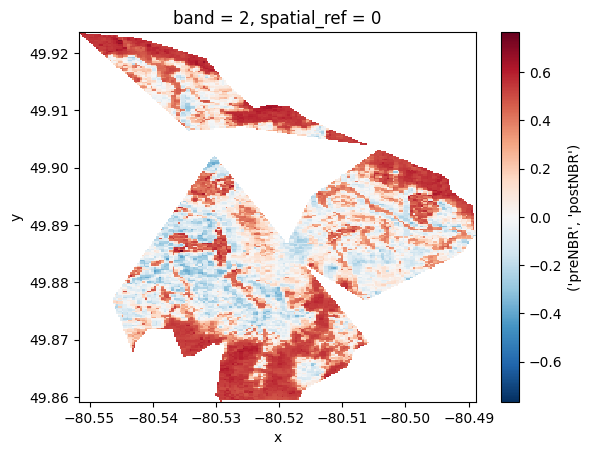

In [31]:
# check raster

fp2= "/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/chp3-sbw-fire/defol_cropped_pp/COC16_1997_1038.tif"
t = rx.open_rasterio(fp2, masked= True,)
t[1].squeeze().plot.imshow()
t

After converting original pp files to netCDF to work better with xarray, lets check to see how it looks



### code to make 3-D array by year

In [256]:
nc2= "/Users/jgoldman/Desktop/chp3/ltr_pre_post/THU37_2007_1662_pp.nc"
t = xr.open_dataset(nc2,decode_coords="all") 
t

preNBR= t.rename_vars(Band1='nbr')['nbr']
postNBR= t.rename_vars(Band2='nbr')['nbr']
preNBR.attrs["long_name"] = "nbr"

preNBR
postNBR = postNBR.assign_coords({
    "lon": preNBR.lon,
    "lat": preNBR.lat,})


postNBR 



ds= xr.concat([preNBR, postNBR], dim=pd.Index([1996, 1998], name ='time'))



# Section 2 - epxlore NBAC

In [581]:
nbac = gpd.read_file('/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/Projects-Data/shield-data/NBAC-shield-1986-2022/nbac-1986-2022-ontario-shield.shp')



In [582]:
nbac2 = nbac


In [583]:
nbac.columns.tolist()
nbac.head()
nbac["COMMENTS"]

0       SAU4[accuracy:AC Accurate (to 10m),weath_ind:7...
1       SAU4[accuracy:AP Approximate (to 500m),weath_i...
2       SAU8[accuracy:AC Accurate (to 10m),weath_ind:6...
3       SAU20[fire_type:IFR,fwi:7,objective:FUL,start_...
4       SAU13[fire_type:IFR,fwi:24,objective:FUL,start...
                              ...                        
2317                                                 Null
2318                                                 None
2319    SLK65[fire_type:IFR,fwi:11,objective:MON,start...
2320                                                 Null
2321                                                 None
Name: COMMENTS, Length: 2322, dtype: object

In [584]:
# select comments and filter to coc16
sep = '['


nbac2['COMMENTS'] = nbac2['COMMENTS'].str.replace('(?<=\[).*', "", regex=True)

nbac2.head()

YEAR  NFIREID  BASRC  FIREMAPS  FIREMAPM  FIRECAUS  BURNCLAS       SDATE   
0  1999.0    694.0    3.0       0.0       3.0       4.0       4.0        None  \
1  1998.0    841.0    3.0       0.0       0.0       4.0       4.0        None   
2  2000.0    528.0    3.0       0.0       3.0       4.0       4.0        None   
3  2011.0    722.0    3.0       2.0       3.0       4.0       4.0  2011-10-09   
4  2007.0    388.0    3.0       2.0       3.0       1.0       4.0  2007-05-13   

        EDATE     AFSDATE     AFEDATE CAPDATE      POLY_HA       ADJ_HA   
0        None  1999-04-23  1999-04-30    None    32.012818    30.372158  \
1        None  1998-04-10  1998-04-11    None     9.442232     9.390455   
2        None  2000-04-25  2000-05-08    None    28.819582    27.453665   
3  2011-10-09  2011-10-08  2011-10-24    None   709.809516   597.535660   
4  2007-07-30  2007-05-13  2007-06-15    None  1555.108435  1270.104833   

   ADJ_FLAG AGENCY  BT_GID           VERSION COMMENTS   
0       2.0     ON   110.0  1999_r9_20210810    SAU4[  \
1       2.0     ON   508.0  1998_r9_20210810    SAU4[   
2       2.0     ON   472.0  2000_r9_20210810    SAU8[   
3       2.0     ON   836.0  2011_r9_20210810   SAU20[   
4       2.0     ON   181.0  2007_r9_20210810   SAU13[   

                                            geometry  
0  POLYGON ((-83.65634 46.36772, -83.65634 46.367...  
1  POLYGON ((-84.09908 46.41307, -84.09908 46.413...  
2  POLYGON ((-83.99699 46.43096, -83.99699 46.430...  
3  POLYGON ((-84.30281 46.75777, -84.30758 46.758...  
4  POLYGON ((-83.28152 46.85578, -83.28139 46.855...

In [585]:
nbac2['COMMENTS'] = nbac2['COMMENTS'].str.replace("[", "")

# change year column to integer
nbac2['YEAR'] = nbac2['YEAR'].astype('int16')

nbac2.head()

#new column which is a concat of comments and year 

nbac2['Fire_ID']=nbac2['COMMENTS'] + "_" + nbac2['YEAR'].astype('str')
nbac2.head()

YEAR  NFIREID  BASRC  FIREMAPS  FIREMAPM  FIRECAUS  BURNCLAS       SDATE   
0  1999    694.0    3.0       0.0       3.0       4.0       4.0        None  \
1  1998    841.0    3.0       0.0       0.0       4.0       4.0        None   
2  2000    528.0    3.0       0.0       3.0       4.0       4.0        None   
3  2011    722.0    3.0       2.0       3.0       4.0       4.0  2011-10-09   
4  2007    388.0    3.0       2.0       3.0       1.0       4.0  2007-05-13   

        EDATE     AFSDATE  ... CAPDATE      POLY_HA       ADJ_HA  ADJ_FLAG   
0        None  1999-04-23  ...    None    32.012818    30.372158       2.0  \
1        None  1998-04-10  ...    None     9.442232     9.390455       2.0   
2        None  2000-04-25  ...    None    28.819582    27.453665       2.0   
3  2011-10-09  2011-10-08  ...    None   709.809516   597.535660       2.0   
4  2007-07-30  2007-05-13  ...    None  1555.108435  1270.104833       2.0   

   AGENCY BT_GID           VERSION COMMENTS   
0      ON  110.0  1999_r9_20210810     SAU4  \
1      ON  508.0  1998_r9_20210810     SAU4   
2      ON  472.0  2000_r9_20210810     SAU8   
3      ON  836.0  2011_r9_20210810    SAU20   
4      ON  181.0  2007_r9_20210810    SAU13   

                                            geometry     Fire_ID  
0  POLYGON ((-83.65634 46.36772, -83.65634 46.367...   SAU4_1999  
1  POLYGON ((-84.09908 46.41307, -84.09908 46.413...   SAU4_1998  
2  POLYGON ((-83.99699 46.43096, -83.99699 46.430...   SAU8_2000  
3  POLYGON ((-84.30281 46.75777, -84.30758 46.758...  SAU20_2011  
4  POLYGON ((-83.28152 46.85578, -83.28139 46.855...  SAU13_2007  

[5 rows x 21 columns]

In [586]:
defol = gpd.read_file("/Users/jgoldman/Desktop/OneDrive - University of Toronto/Data/chapter_3/on-qc-defol.shp")
# change fire id column to match
defol['Fire_ID']= defol['Fire_ID'].str.split('_').str[:2].str.join('_')

defol.head()


Fire_ID Fire_Year  defoliated   
0   CHA8_2012      2012         1.0  \
1  COC16_1997      1997         1.0   
2  COC23_1995      1995         1.0   
3  COC38_1995      1995         1.0   
4  DRY27_1996      1996         1.0   

                                            geometry  
0  POLYGON ((-82.47142 48.33225, -82.46911 48.331...  
1  MULTIPOLYGON (((-80.51622 49.86124, -80.51691 ...  
2  POLYGON ((-81.32426 50.19131, -81.32550 50.191...  
3  MULTIPOLYGON (((-81.51191 50.14156, -81.51111 ...  
4  MULTIPOLYGON (((-90.36624 50.04934, -90.36621 ...

In [587]:
#Get list from defol
fireIDs= defol['Fire_ID'].tolist()

#
nbac3 = nbac2.query('Fire_ID.isin(@fireIDs)')

In [588]:
nbac3
thu= nbac3[nbac3.Fire_ID == "THU37_2007"]
thu2 = defol[defol.Fire_ID == "THU37_2007"]

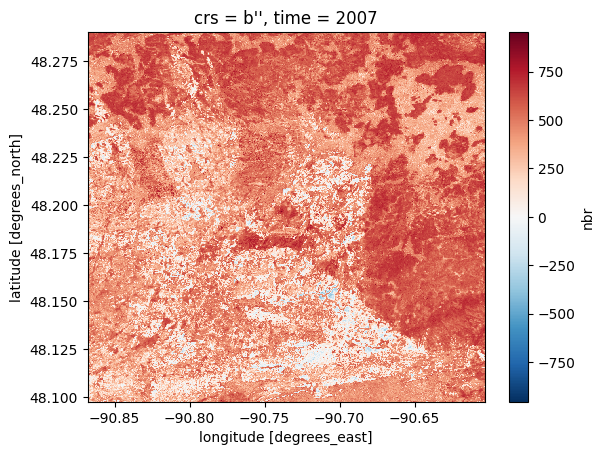

In [589]:
air2d = ds.isel(time=1)

air2d.plot()



<Axes: title={'center': "crs = b'', time = 2007"}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

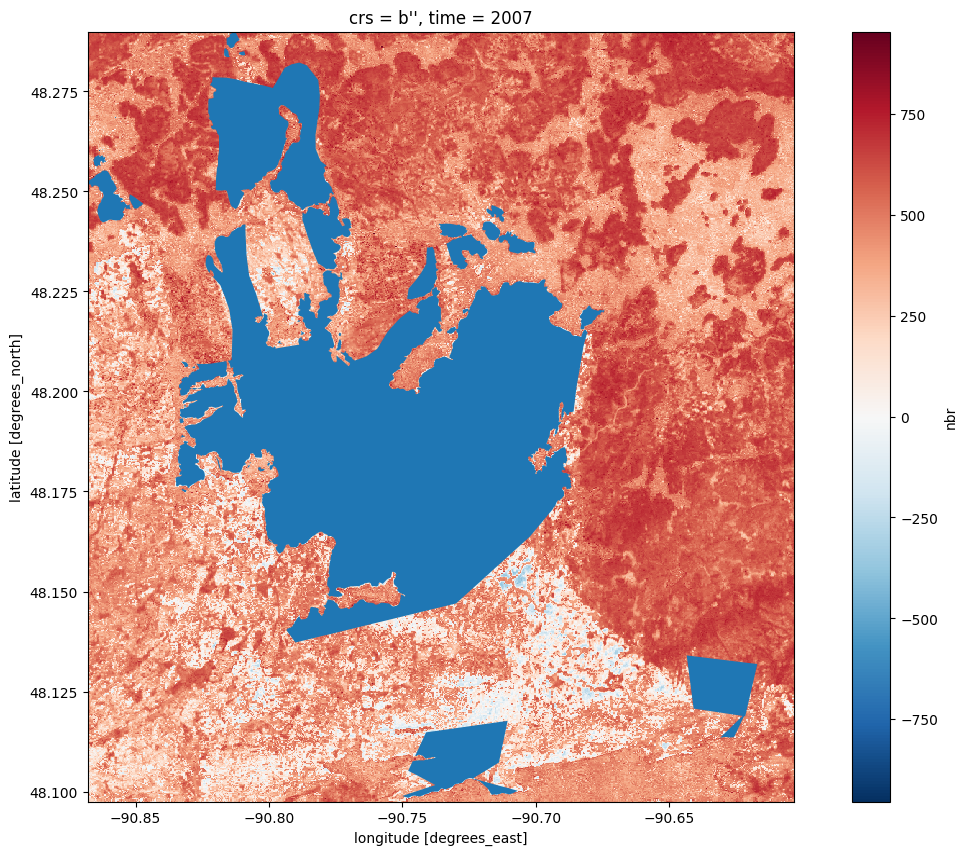

In [590]:
fig, ax = plt.subplots(figsize=(15, 10))
air2d.plot(ax=ax) 
thu2.plot(ax=ax)    # Plot the vector data on the subplot


<Axes: title={'center': "crs = b'', time = 2007"}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

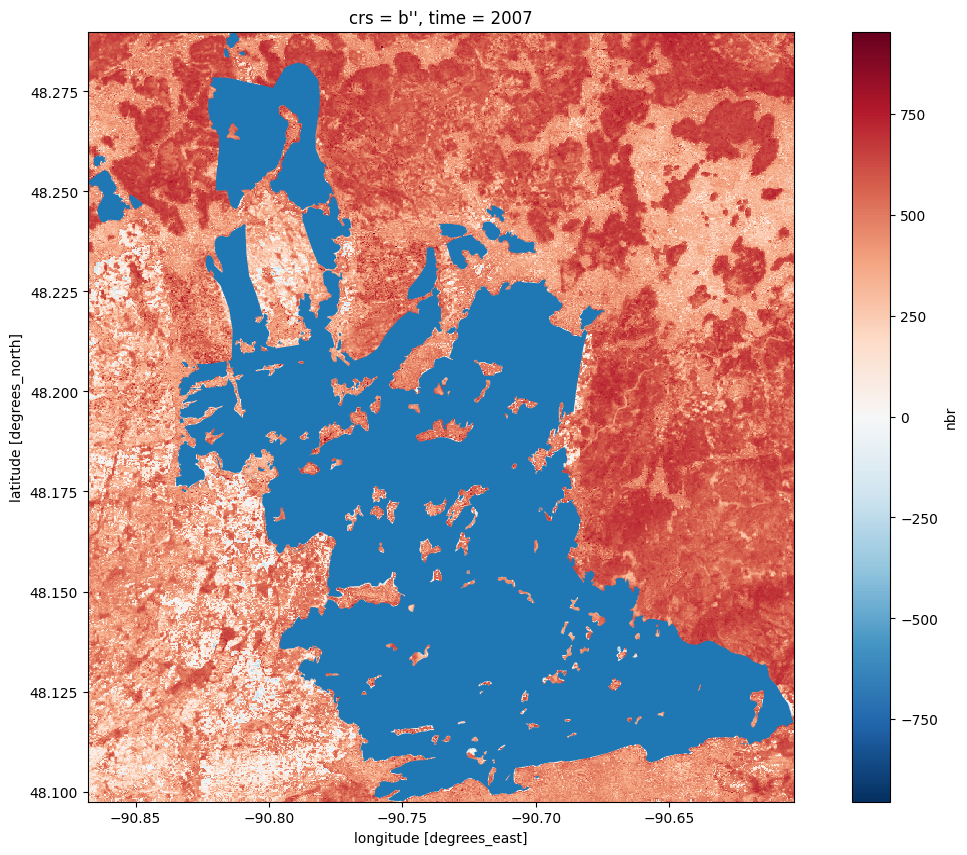

In [591]:
fig, ax = plt.subplots(figsize=(15, 10))
air2d.plot(ax=ax) 
thu.plot(ax=ax)    # Plot the vector data on the subplot


## match each dataframe based on the centroid of each fire perimeter



In [592]:
nbac["centroid"] = nbac["geometry"].centroid

/var/folders/ct/ddw0sd294ls6ktmlw9l8bwgm0000gn/T/ipykernel_27782/1439265844.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nbac["centroid"] = nbac["geometry"].centroid


In [593]:
nbac['savedgeom'] =nbac.geometry

In [594]:
defol["centroid"] = defol["geometry"].centroid
defol = defol.drop(columns=['geometry'])
defol

/var/folders/ct/ddw0sd294ls6ktmlw9l8bwgm0000gn/T/ipykernel_27782/943717339.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  defol["centroid"] = defol["geometry"].centroid


Fire_ID Fire_Year  defoliated                    centroid
0    CHA8_2012      2012         1.0  POINT (-82.46589 48.33120)
1   COC16_1997      1997         1.0  POINT (-80.52080 49.88706)
2   COC23_1995      1995         1.0  POINT (-81.32506 50.19205)
3   COC38_1995      1995         1.0  POINT (-81.57739 50.11347)
4   DRY27_1996      1996         1.0  POINT (-90.37125 50.05905)
..         ...       ...         ...                         ...
66      QC_783      1996         1.0  POINT (-70.63442 49.28901)
67      QC_788      1996         1.0  POINT (-70.99154 50.05970)
68      QC_792      1996         1.0  POINT (-71.50781 50.35702)
69       QC_81      1991         1.0  POINT (-72.42366 50.14717)
70       QC_96      1991         1.0  POINT (-76.14857 51.41383)

[71 rows x 4 columns]

In [595]:
# set geo to centroid
defol = defol.set_geometry("centroid")

In [596]:
# join defol and nbac dataframe based on the nearest centroid
defol_w_nbac = defol.sjoin_nearest(nbac, distance_col="centroid", how="left")
defol_w_nbac

/opt/homebrew/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Fire_ID_left Fire_Year  defoliated                  centroid_x  centroid_y   
0     CHA8_2012      2012         1.0  POINT (-82.46589 48.33120)    0.000000  \
1    COC16_1997      1997         1.0  POINT (-80.52080 49.88706)    0.000000   
2    COC23_1995      1995         1.0  POINT (-81.32506 50.19205)    0.006637   
3    COC38_1995      1995         1.0  POINT (-81.57739 50.11347)    0.003100   
4    DRY27_1996      1996         1.0  POINT (-90.37125 50.05905)    0.000204   
..          ...       ...         ...                         ...         ...   
66       QC_783      1996         1.0  POINT (-70.63442 49.28901)    7.162504   
67       QC_788      1996         1.0  POINT (-70.99154 50.05970)    7.358044   
68       QC_792      1996         1.0  POINT (-71.50781 50.35702)    7.189723   
69        QC_81      1991         1.0  POINT (-72.42366 50.14717)    6.422188   
70        QC_96      1991         1.0  POINT (-76.14857 51.41383)    3.447695   

    index_right  YEAR  NFIREID  BASRC  FIREMAPS  ...      POLY_HA   
0           194  2012   1040.0    3.0       0.0  ...   193.811600  \
1           305  1997    350.0    4.0       9.0  ...  2700.557627   
2           785  1995   1187.0    4.0       9.0  ...  7638.842783   
3           777  1995   1200.0    4.0       9.0  ...  1542.331795   
4           642  1996    627.0    4.0       9.0  ...   655.611595   
..          ...   ...      ...    ...       ...  ...          ...   
66           16  2000    527.0    3.0       0.0  ...    59.724377   
67           16  2000    527.0    3.0       0.0  ...    59.724377   
68           16  2000    527.0    3.0       0.0  ...    59.724377   
69           16  2000    527.0    3.0       0.0  ...    59.724377   
70          810  2005    454.0    1.0       9.0  ...  3756.398058   

         ADJ_HA  ADJ_FLAG AGENCY  BT_GID           VERSION COMMENTS   
0    171.535929       2.0     ON  1074.0  2012_r9_20210810     CHA8  \
1   2700.557627       0.0     ON  1055.0  1997_r9_20210810     None   
2   7638.842783       0.0     ON  2302.0  1995_r9_20210810     None   
3   1542.331795       0.0     ON  2010.0  1995_r9_20210810     None   
4    655.611595       0.0     ON  1281.0  1996_r9_20210810     None   
..          ...       ...    ...     ...               ...      ...   
66    55.316311       2.0     ON   286.0  2000_r9_20210810     KEM2   
67    55.316311       2.0     ON   286.0  2000_r9_20210810     KEM2   
68    55.316311       2.0     ON   286.0  2000_r9_20210810     KEM2   
69    55.316311       2.0     ON   286.0  2000_r9_20210810     KEM2   
70  3756.398058       0.0     QC    83.0  2005_r9_20210810     Null   

   Fire_ID_right                                          savedgeom   
0      CHA8_2012  POLYGON ((-82.45267 48.33240, -82.45427 48.331...  \
1            NaN  MULTIPOLYGON (((-80.55900 49.93884, -80.55900 ...   
2            NaN  MULTIPOLYGON (((-81.23068 50.34201, -81.23068 ...   
3            NaN  MULTIPOLYGON (((-81.43903 50.16766, -81.43861 ...   
4            NaN  MULTIPOLYGON (((-90.38288 50.08340, -90.38371 ...   
..           ...                                                ...   
66     KEM2_2000  POLYGON ((-76.51540 45.18656, -76.51540 45.186...   
67     KEM2_2000  POLYGON ((-76.51540 45.18656, -76.51540 45.186...   
68     KEM2_2000  POLYGON ((-76.51540 45.18656, -76.51540 45.186...   
69     KEM2_2000  POLYGON ((-76.51540 45.18656, -76.51540 45.186...   
70     Null_2005  MULTIPOLYGON (((-79.51691 50.60365, -79.51691 ...   

                      centroid  
0   POINT (-82.46714 48.33321)  
1   POINT (-80.54322 49.89333)  
2   POINT (-81.27545 50.25490)  
3   POINT (-81.55848 50.12002)  
4   POINT (-90.38770 50.07221)  
..                         ...  
66  POINT (-76.51454 45.19045)  
67  POINT (-76.51454 45.19045)  
68  POINT (-76.51454 45.19045)  
69  POINT (-76.51454 45.19045)  
70  POINT (-79.51732 50.62760)  

[71 rows x 28 columns]

In [597]:
# keep only fires with the ON agency
defol_w_nbac_on = defol_w_nbac[defol_w_nbac.AGENCY == "ON"] 

In [598]:
##### filter dataframe
# remove QC fires 
substring = "QC"
filter = defol_w_nbac_on['Fire_ID'].str.contains(substring)
filtered_df = defol_w_nbac_on[~filter]

# filter all fires and make sure fire years between two columns ( 1 from defol and 1 from nbac) match
filtered_df['YEAR'] = filtered_df['YEAR'].astype('int16') # change to integer
filtered_df = filtered_df.rename(columns={'YEAR': 'year'}) #rename year
filtered_df['Fire_Year'] = filtered_df['Fire_Year'].astype('int16') # change to integer
f2 = filtered_df.query("Fire_Year == year") # query


KeyError: 'Fire_ID'

Save results file while removing the the the centroids.

In [ ]:
#remove unwanted columns
f2 = f2.drop(columns=['centroid', 'centroid_x', 'centroid_y', 'COMMENTS'])
#change name of geometry column back to geometry
f2 = f2.rename(columns={'savedgeom': 'geometry'})
#convert to geodataframe
f2 = gpd.GeoDataFrame(f2, crs = "EPSG:4326")
#save file
f2.to_file('/Users/jgoldman/Desktop/chp3/fire_perimeters/nbac/on-nbac-matched-pairs-full-perimeters', driver='ESRI Shapefile')
f2


# Section 3 - make function to loop through fires and make array stack

Band-order:

1. nbr_2yr
2. nbr_3yr
3. nbr_4yr
4. nbr_5yr
5. nbr_6yr
6. nbr_7yr
7. nbr_8yr
8. nbr_9yr
9. nbr_10yr
10. nbr_yof

In [525]:
def combine_nc_to_xarray(nbr_img, pp_img, filename):
    img = nbr_img
    img2 = pp_img
    # get years
    year = int(fire_year_from_base(filename)) #coerce to integer
    start = year - 1
    end = year + 11 # add 10 years 
    years = list(range(start, end))
    #filter bands
    nbr0=img.rename_vars(Band10="nbr")['nbr']
    nbr2=img.rename_vars(Band1="nbr")['nbr']
    nbr3=img.rename_vars(Band2="nbr")['nbr']
    nbr4=img.rename_vars(Band3="nbr")['nbr']
    nbr5=img.rename_vars(Band4="nbr")['nbr']
    nbr6=img.rename_vars(Band5="nbr")['nbr']
    nbr7=img.rename_vars(Band6="nbr")['nbr']
    nbr8=img.rename_vars(Band7="nbr")['nbr']
    nbr9=img.rename_vars(Band8="nbr")['nbr']
    nbr10=img.rename_vars(Band9="nbr")['nbr']

    # make sure coordinates match
    nbr2= match_coords(nbr2, nbr0)
    nbr3= match_coords(nbr3, nbr0)
    nbr4= match_coords(nbr4, nbr0)
    nbr5= match_coords(nbr5, nbr0)
    nbr6= match_coords(nbr6, nbr0)
    nbr7= match_coords(nbr7, nbr0)
    nbr8= match_coords(nbr8, nbr0)
    nbr9= match_coords(nbr9, nbr0)
    nbr10= match_coords(nbr10, nbr0)

    # pre nbr
    preNBR= img2.rename_vars(Band1='nbr')['nbr']
    postNBR= img2.rename_vars(Band2='nbr')['nbr']

    # make sure coordinates match
    postNBR= match_coords(postNBR, nbr0)
    preNBR= match_coords(preNBR, nbr0)

    #concat
    da = xr.concat([preNBR, nbr0, postNBR, nbr2, nbr3, nbr4, nbr5, nbr6, nbr7, nbr8, nbr9, nbr10], dim=pd.Index(years, name='time'))
    
    da.attrs['long_name'] = "nbr"
    return(da)



In [557]:
nbr_in_path= "/Users/jgoldman/Desktop/chp3/ltr_nbr/"
pp_in_path= "/Users/jgoldman/Desktop/chp3/ltr_pre_post/"
out_path = "/Users/jgoldman/Desktop/chp3/ltr_nbr_combined/"

combine_write_to_xarray(nbr_in_path, pp_in_path, out_path)

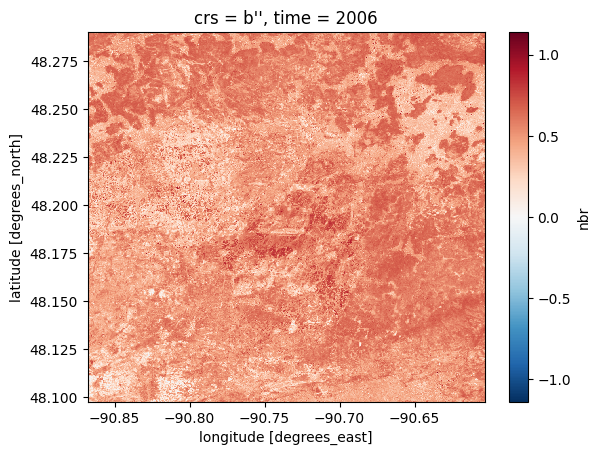

In [560]:
nbr_nc= "/Users/jgoldman/Desktop/chp3/ltr_nbr_combined/THU37_2007_1662.nc"
img= xr.open_dataset(nbr_nc, decode_coords="all")



dspre = ds.isel(time=0)
dsyof = ds.isel(time=1)
dspost = ds.isel(time=2)
ds10 = ds.isel(time=10)

dspre.plot()


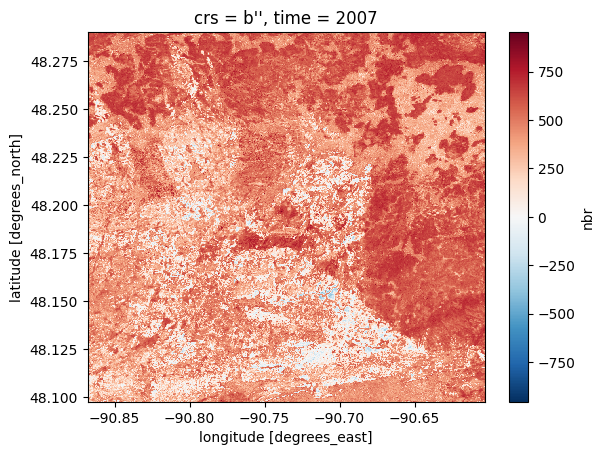

In [529]:
dsyof.plot()


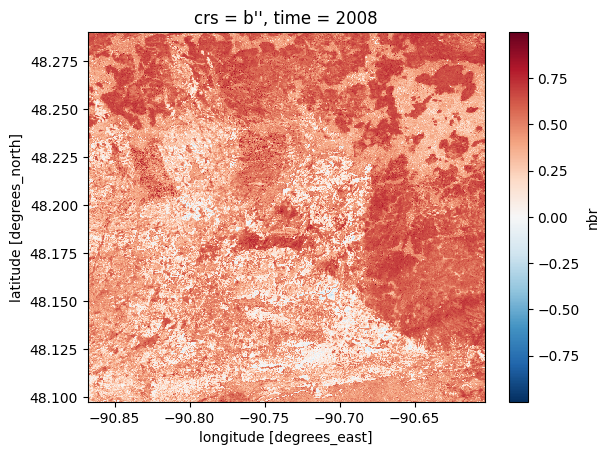

In [530]:

dspost.plot()


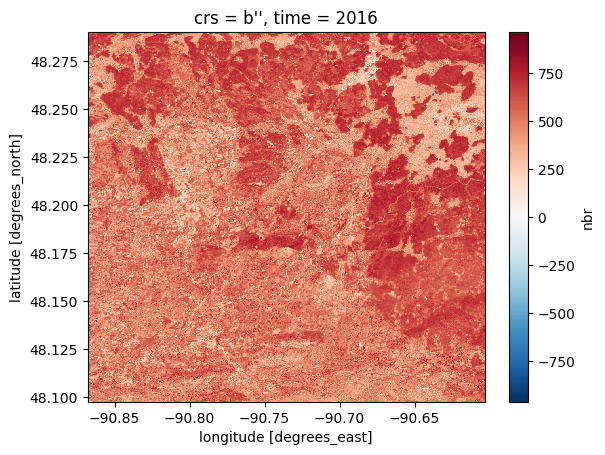

In [531]:

ds10.plot()

# Section 4 remove fires from on defoliated that are not in nbac perimeters

In [664]:


def clipRasters(in_path, shpfile, out_path):
 pathlist = Path(in_path).rglob('*.nc')
 for path in pathlist:
  path_in_str = str(path)
  src = xr.open_dataset(path, decode_coords=True)
  name = getName(path_in_str)
  src.rio.write_crs("epsg:4326", inplace=True)
  print(name)
  src_lonlat = src.rio.reproject("epsg:4326") 
  shp = gpd.read_file(shpfile)
  if shp.isin([name]).any().any() == False:
    continue
  else:
    shp = shp[shp.Fire_ID == name]
    clipped = src_lonlat.rio.clip(shp.geometry.values, shp.crs, drop=True, invert=False)
    out_dir = out_path + name +".nc"
    vars_list = list(clipped.data_vars)  
    for var in vars_list:  
        del clipped[var].attrs['grid_mapping']
    clipped.to_netcdf(out_dir)


In [666]:
in_path= "/Users/jgoldman/Desktop/chp3/ltr_nbr_combined/"
shpfile= "/Users/jgoldman/Desktop/chp3/fire_perimeters/defoliated_or_nondefoliated/ON-QC/non-defoliated/on-qc-non-defol-nbac-v1.shp"
out_path = "/Users/jgoldman/Desktop/chp3/clipped/nbr/non-defoliated/"

clipRasters(in_path, shpfile, out_path)

QC_319_1986
THU74_1996_1129
QC_50_1986
QC_122_1988
QC_739_1996
QC_59_1986
RED58_1999_677
QC_508_1996
QC_1218_1995
QC_728_1996
THU37_2007_1662
QC_96_1991
QC_1824_2010
SAU4_1998_335
QC_1017_1995
THU130_1991_1263
QC_788_1996
QC_1445_1995
QC_33_1986
QC_1234_1995
QC_783_1996
NIP56_1998_832
RED62_2002_93
COC23_1995_1273
THU71_1998_684
QC_1425_1995
TER7_1986_83
QC_107_1988
QC_750_1996
QC_1191_1995
COC16_1997_1038
QC_101_1990
RED25_2010_1756
QC_792_1996
SLK11_2007_1658
NIP230_1998_821
THU36_1996_1313
RED208_1988_862
THU144_2006_1638
QC_547_2010
NIP51_1996_620
QC_64_1991
FOR13_1987_316
QC_65_1990
COC38_1995_629
PEM8_1999_1450
QC_444_1991
QC_103_1988
RED7_1986_119
PEM4_1999_1091
QC_745_1996
QC_1442_1995
QC_81_1991
IGN9_1987_492
SLK60_1996_884
QC_1432_1995
DRY27_1996_1121
QC_1248_1995
THU142_2006_1634
QC_480_1996
QC_63_1987
QC_533_1996
NIP44_2000_29
QC_377_1997
NIP20_2005_1521
NIP136_1995_1299
NIP9_1992_1122
QC_757_1996


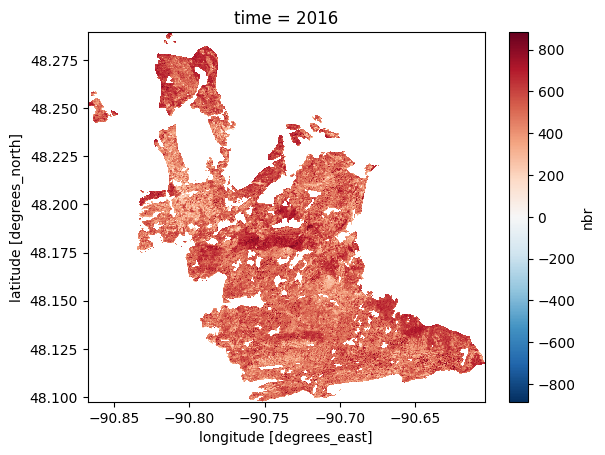

In [675]:
img = xr.open_dataset("/Users/jgoldman/Desktop/chp3/clipped/nbr/defoliated/THU37_2007_1662.nc", decode_coords=True)

img
imgpre = img.isel(time=10)


imgpre['nbr'].plot()
